This notebook loads the data and picks out random subsets if a smaller dataset is desired. Then it trains and tests my implementation of the DeepShadows CNN with DES images, before performing a transfer learning test on HSC images. This code is heavily based on the DeepShadows.ipynb notebook in the repository: https://github.com/dtanoglidis/DeepShadows

In [1]:
# imports
import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras import regularizers
from tensorflow.keras import optimizers
from keras import layers as lyr
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
%matplotlib inline

## Training

In [2]:
# load the data

np.random.seed(788739854) # set a seed to pick out consistent subsets of the full dataset when re-running

batch_size = 64 # batch size, real DeepShadows uses 64

# load the full datasets
# examples
X_tr = np.float64(np.load('Data/X_train.npy'))[0,:] # training
X_val = np.float64(np.load('Data/X_val.npy'))[0,:] # validation
X_test = np.float64(np.load('Data/X_test.npy'))[0,:] # test
# labels
y_tr = np.int64(np.load('Data/y_train.npy'))[0,:] # training
y_val = np.int64(np.load('Data/y_val.npy'))[0,:] # validation
y_test = np.int64(np.load('Data/y_test.npy'))[0,:] # test

# if we want to use a subset of the data rather than the whole thing, pick out the subset randomly
# [train, validation, test] list with the desired number of batches in each set
num_batches = np.array([468, 77, 77]) # full dataset

# draw random samples of indices for each set of the desired lengths
tr_idx = np.random.choice(np.arange(len(y_tr)), size=num_batches[0]*batch_size, replace=False)
val_idx = np.random.choice(np.arange(len(y_val)), size=num_batches[1]*batch_size, replace=False)
test_idx = np.random.choice(np.arange(len(y_test)), size=num_batches[2]*batch_size, replace=False)

# then pick these out
X_tr = X_tr[tr_idx]
y_tr = y_tr[tr_idx]

X_val = X_val[val_idx]
y_val = y_val[val_idx]

X_test = X_test[test_idx]
y_test = y_test[test_idx]

In [3]:
# Define the DeepShadows CNN
def DeepShadows():
    # architecture
    net = keras.models.Sequential([
        # input layer is the same shape as an image, with the channels last
        lyr.InputLayer((64,64,3)),
        # Each of the first three blocks contains a convolutional layer with relu activation and weight decay
        lyr.Conv2D(filters=16, kernel_size=3, padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.13)),
        # followed by batch normalization
        lyr.BatchNormalization(),
        # and max pooling
        lyr.MaxPool2D(pool_size=2, strides=None, padding='valid'),
        # finally, apply dropout
        lyr.Dropout(rate=0.4),
        # repeat this block twice more, while doubling the number of channels each time
        lyr.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.13)),
        lyr.BatchNormalization(),
        lyr.MaxPool2D(pool_size=2, strides=None, padding='valid'),
        lyr.Dropout(rate=0.4),
        # last block, double channels again
        lyr.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.13)),
        lyr.BatchNormalization(),
        lyr.MaxPool2D(pool_size=2, strides=None, padding='valid'),
        lyr.Dropout(rate=0.4),
        # flatten the output so it can be put into the dense layers
        lyr.Flatten(),
        # fully connected layers
        lyr.Dense(units=1024, activation='relu',kernel_regularizer=regularizers.l2(0.12)), # lower the weight decay parameter a bit
        # last layer uses sigmoid activation to output a single probability that the image contains a LSBG
        lyr.Dense(units=1, activation='sigmoid')
    ])
    
    # compile the network for training. 
    # DeepShadows uses Adadelta with a base learning rate of 0.1,
    # cross-entropy loss, 
    # and we want the network to be evaluated by its accuracy
    net.compile(optimizer=optimizers.Adadelta(0.1), loss='binary_crossentropy', metrics=['accuracy'])
    
    return net

In [4]:
# training
n_epochs = 100 # number of epochs

# callback function to save a checkpoint every 10 epochs during training
checkpt = keras.callbacks.ModelCheckpoint(filepath='training_checkpoints/checkpoint', verbose=1, 
                                          save_weights_only=True, save_freq=int(10*num_batches[0]))

# create and train the network
net = DeepShadows()
net.fit(x=X_tr, y=y_tr, epochs=n_epochs, batch_size=batch_size, shuffle=True, validation_data=(X_val,y_val), 
        callbacks=[checkpt])

Epoch 1/100
468/468 [==============================] - 64s 135ms/step - loss: 53.2198 - accuracy: 0.8273 - val_loss: 5.7890 - val_accuracy: 0.8119
Epoch 2/100
468/468 [==============================] - 64s 137ms/step - loss: 2.2347 - accuracy: 0.8765 - val_loss: 1.0121 - val_accuracy: 0.8553
Epoch 3/100
468/468 [==============================] - 62s 132ms/step - loss: 0.6619 - accuracy: 0.8929 - val_loss: 0.5240 - val_accuracy: 0.8933
Epoch 4/100
468/468 [==============================] - 59s 127ms/step - loss: 0.4575 - accuracy: 0.9018 - val_loss: 0.4324 - val_accuracy: 0.8925
Epoch 5/100
468/468 [==============================] - 60s 128ms/step - loss: 0.3955 - accuracy: 0.9055 - val_loss: 0.3660 - val_accuracy: 0.9115
Epoch 6/100
468/468 [==============================] - 62s 133ms/step - loss: 0.3617 - accuracy: 0.9074 - val_loss: 0.3379 - val_accuracy: 0.9109
Epoch 7/100
468/468 [==============================] - 63s 135ms/step - loss: 0.3402 - accuracy: 0.9073 - val_loss: 0.3136 

Epoch 52/100
468/468 [==============================] - 65s 139ms/step - loss: 0.2608 - accuracy: 0.9156 - val_loss: 0.2502 - val_accuracy: 0.9156
Epoch 53/100
468/468 [==============================] - 65s 140ms/step - loss: 0.2579 - accuracy: 0.9150 - val_loss: 0.2498 - val_accuracy: 0.9182
Epoch 54/100
468/468 [==============================] - 65s 139ms/step - loss: 0.2598 - accuracy: 0.9148 - val_loss: 0.2702 - val_accuracy: 0.9099
Epoch 55/100
468/468 [==============================] - 65s 139ms/step - loss: 0.2597 - accuracy: 0.9140 - val_loss: 0.2390 - val_accuracy: 0.9225
Epoch 56/100
468/468 [==============================] - 65s 139ms/step - loss: 0.2605 - accuracy: 0.9148 - val_loss: 0.2662 - val_accuracy: 0.9105
Epoch 57/100
468/468 [==============================] - 65s 140ms/step - loss: 0.2586 - accuracy: 0.9156 - val_loss: 0.2527 - val_accuracy: 0.9166
Epoch 58/100
468/468 [==============================] - 65s 139ms/step - loss: 0.2590 - accuracy: 0.9153 - val_loss: 0

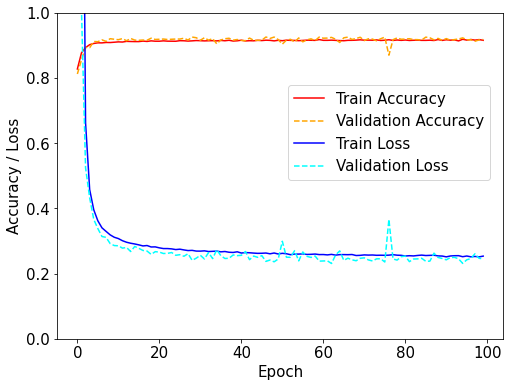

In [18]:
# plot the results
plt.rcParams.update({'font.size': 15})

t = np.arange(n_epochs) # array for epoch number

# get performance metrics
performance_data = net.history.history

tr_acc = performance_data['accuracy']
val_acc = performance_data['val_accuracy']
tr_loss = performance_data['loss']
val_loss = performance_data['val_loss']

# save these so we can mess with the plot without retraining
np.save('plot_data/tr_acc', tr_acc)
np.save('plot_data/val_acc', val_acc)
np.save('plot_data/tr_loss', tr_loss)
np.save('plot_data/val_loss', val_loss)

# and plot everything up
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(t, tr_acc, c='r', label='Train Accuracy')
ax.plot(t, val_acc, c='orange', linestyle='dashed', label='Validation Accuracy')
ax.plot(t, tr_loss, c='b', label='Train Loss')
ax.plot(t, val_loss, c='cyan', linestyle='dashed', label='Validation Loss')

ax.set(xlabel='Epoch', ylabel='Accuracy / Loss', ylim=(0,1))

ax.legend(bbox_to_anchor=(0.5,0.8))
plt.show()

In [19]:
# save the trained network
net.save('Trained_networks/DeepShadows_tf')

INFO:tensorflow:Assets written to: Trained_networks/DeepShadows_tf/assets


## Testing

In [20]:
# evaluate the network's accuracy on the test set
test_loss, test_acc = net.evaluate(X_test, y_test, verbose=2)
print('Test Accuracy: {}'.format(test_acc))

154/154 - 4s - loss: 0.2598 - accuracy: 0.9117 - 4s/epoch - 24ms/step
Test Accuracy: 0.9117289185523987


In [21]:
# compute the confusion matrix for the test set
thres = 0.5 # threshold probability for a LSBG prediction

y_prob = net.predict(X_test) # get predicted probabilities
# and figure out which indices are over the threshold probability
LSBG_idx = np.argwhere(y_prob > thres)

# now make an array of the predicted classes based on the threshold
y_pred = np.zeros_like(y_prob, dtype=int)
y_pred[LSBG_idx] = 1

# compute the confusion matrix
conf_mat_DES = confusion_matrix(y_test, y_pred) # rows are true, columns are predicted
# and print out the entries nicely
print("True positives:  {:4}".format(conf_mat_DES[1,1]))
print("True negatives:  {:4}".format(conf_mat_DES[0,0]))
print("False positives: {:4}".format(conf_mat_DES[0,1]))
print("False negatives: {:4}".format(conf_mat_DES[1,0]))

True positives:  2338
True negatives:  2154
False positives:  312
False negatives:  124


## Transfer Learning

In [22]:
# load the HSC data

batch_size_tl = 32 # batch size, real DeepShadows uses 32 for retraining

# load the full HSC datasets since there's not that many
# examples
X_tr_hsc = np.float64(np.load('Data/X_HSC_train.npy'))[0,:] # training
X_test_hsc = np.float64(np.load('Data/X_HSC_test.npy'))[0,:] # test
# labels
y_tr_hsc = np.int64(np.load('Data/y_HSC_train.npy'))[0,:] # training
y_test_hsc = np.int64(np.load('Data/y_HSC_test.npy'))[0,:] # test

# load the saved trained network
net = keras.models.load_model('Trained_networks/DeepShadows_tf')

In [23]:
# evaluate the un-retrained network's accuracy on the test set
test_loss_hsc, test_acc_hsc = net.evaluate(X_test_hsc, y_test_hsc, verbose=2)
print('Test Accuracy: {}'.format(test_acc_hsc))

30/30 - 1s - loss: 0.7095 - accuracy: 0.7604 - 854ms/epoch - 28ms/step
Test Accuracy: 0.7604166865348816


In [24]:
# compute the confusion matrix for the test set
y_prob_hsc = net.predict(X_test_hsc) # get predicted probabilities
# and figure out which indices are over the threshold probability
LSBG_idx_hsc = np.argwhere(y_prob_hsc > thres)

# now make an array of the predicted classes based on the threshold
y_pred_hsc = np.zeros_like(y_prob_hsc, dtype=int)
y_pred_hsc[LSBG_idx_hsc] = 1

# compute the confusion matrix
conf_mat_HSC = confusion_matrix(y_test_hsc, y_pred_hsc) # rows are true, columns are predicted
# and print out the entries nicely
print("True positives:  {:4}".format(conf_mat_HSC[1,1]))
print("True negatives:  {:4}".format(conf_mat_HSC[0,0]))
print("False positives: {:4}".format(conf_mat_HSC[0,1]))
print("False negatives: {:4}".format(conf_mat_HSC[1,0]))

True positives:   336
True negatives:   394
False positives:   86
False negatives:  144


In [25]:
# now, recompile and train the model with a much smaller learning rate (transfer learning)
n_epochs_tl = 30 # number of transfer learning epochs

# recompile
net.compile(optimizer=optimizers.Adadelta(0.005), loss='binary_crossentropy', metrics=['accuracy'])

# and train. We won't save checkpoints this time since this step goes quite quickly
net.fit(x=X_tr_hsc, y=y_tr_hsc, epochs=n_epochs_tl, batch_size=batch_size_tl, shuffle=True)

Epoch 1/30
10/10 [==============================] - 1s 90ms/step - loss: 0.5945 - accuracy: 0.8000
Epoch 2/30
10/10 [==============================] - 1s 81ms/step - loss: 0.4760 - accuracy: 0.8188
Epoch 3/30
10/10 [==============================] - 1s 81ms/step - loss: 0.4640 - accuracy: 0.8250
Epoch 4/30
10/10 [==============================] - 1s 82ms/step - loss: 0.4389 - accuracy: 0.8406
Epoch 5/30
10/10 [==============================] - 1s 78ms/step - loss: 0.4145 - accuracy: 0.8375
Epoch 6/30
10/10 [==============================] - 1s 80ms/step - loss: 0.4081 - accuracy: 0.8438
Epoch 7/30
10/10 [==============================] - 1s 92ms/step - loss: 0.4088 - accuracy: 0.8500
Epoch 8/30
10/10 [==============================] - 1s 87ms/step - loss: 0.3959 - accuracy: 0.8656
Epoch 9/30
10/10 [==============================] - 1s 82ms/step - loss: 0.3981 - accuracy: 0.8406
Epoch 10/30
10/10 [==============================] - 1s 83ms/step - loss: 0.3795 - accuracy: 0.8406
Epoch 11/

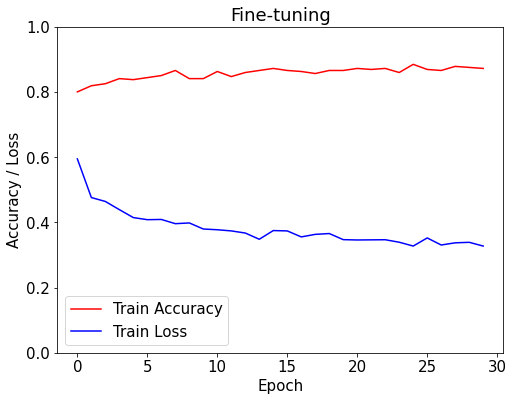

In [26]:
# plot the results
t = np.arange(n_epochs_tl) # array for epoch number

# get performance metrics
performance_data = net.history.history

tr_acc = performance_data['accuracy']
tr_loss = performance_data['loss']

# and plot everything up
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(t, tr_acc, c='r', label='Train Accuracy')
ax.plot(t, tr_loss, c='b', label='Train Loss')

ax.set(title='Fine-tuning', xlabel='Epoch', ylabel='Accuracy / Loss', ylim=(0,1))

ax.legend()
plt.show()

In [27]:
# save the retuned network
net.save('Trained_networks/DeepShadows_tf_HSC')

INFO:tensorflow:Assets written to: Trained_networks/DeepShadows_tf_HSC/assets


In [28]:
# evaluate the retrained network's accuracy on the test set
test_loss_HSC_tuned, test_acc_HSC_tuned = net.evaluate(X_test_hsc, y_test_hsc, verbose=2)
print('Test Accuracy: {}'.format(test_acc_HSC_tuned))

30/30 - 1s - loss: 0.4025 - accuracy: 0.8510 - 849ms/epoch - 28ms/step
Test Accuracy: 0.8510416746139526


In [29]:
# compute the confusion matrix for the test set
y_prob_hsc_tuned = net.predict(X_test_hsc) # get predicted probabilities
# and figure out which indices are over the threshold probability
LSBG_idx_hsc_tuned = np.argwhere(y_prob_hsc_tuned > thres)

# now make an array of the predicted classes based on the threshold
y_pred_hsc_tuned = np.zeros_like(y_prob_hsc_tuned, dtype=int)
y_pred_hsc_tuned[LSBG_idx_hsc_tuned] = 1

# compute the confusion matrix
conf_mat_HSC_tuned = confusion_matrix(y_test_hsc, y_pred_hsc_tuned) # rows are true, columns are predicted
# and print out the entries nicely
print("True positives:  {:4}".format(conf_mat_HSC_tuned[1,1]))
print("True negatives:  {:4}".format(conf_mat_HSC_tuned[0,0]))
print("False positives: {:4}".format(conf_mat_HSC_tuned[0,1]))
print("False negatives: {:4}".format(conf_mat_HSC_tuned[1,0]))

True positives:   433
True negatives:   384
False positives:   96
False negatives:   47
